In [1]:
const int Np=7;
double d[Np]={0 , 100 ,200, 300 , 400 , 500 , 600 };
double n[Np]={36 , 24 , 20 , 20 ,  20  , 24  , 36 };
double k[Np]={36 , 23 , 20 , 15  ,  4  ,  3  ,  0 };

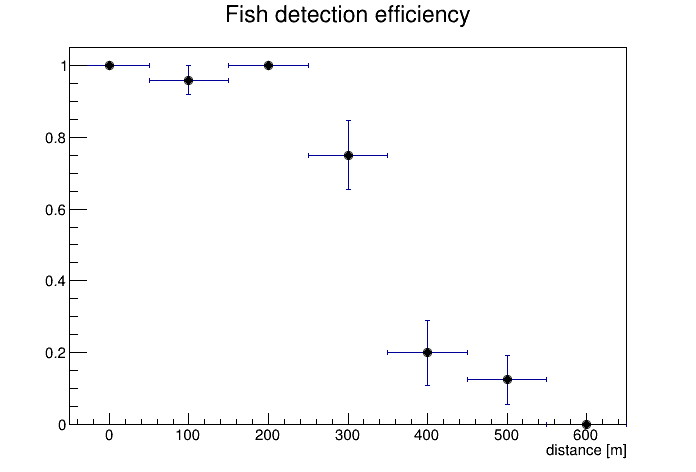

In [2]:
TH1D* hn=new TH1D("hn","All",Np, -50., 650.);
TH1D* hk=new TH1D("hk","Successes",Np, -50., 650.);
TH1D* heff=new TH1D("heff","Fish detection efficiency",Np, -50., 650.);
for (int i=0; i<Np; i++) {
    hn->SetBinContent(i+1, n[i]);
    hk->SetBinContent(i+1, k[i]);
}
  
heff->Divide(hk, hn, 1, 1, "B");
heff->SetMarkerStyle(20);
heff->SetXTitle("distance [m]");
heff->SetStats(0);
TCanvas* c= new TCanvas();
heff->Draw("e0,x0");
c->Draw();

In [3]:
void betaConfidenceLevel(  double alpha, double beta, double CL=0.6826895) {
  Printf("    E(eff)=%.3f    mode(eff)=%.3f", 
     alpha/(alpha+beta),
     TMath::Min(1.,(alpha-1)/(alpha+beta-2)) );
  Printf("    Confidence interval@%.1f%% CL : %.3f < eff < %.3f",
     CL*100., ROOT::Math::beta_quantile ( (1-CL)/2. , alpha, beta ), 
     ROOT::Math::beta_quantile ( (1+CL)/2. , alpha, beta ) );
}

In [4]:
void plotBayesianPosterior(int k, int n) {

  TF1* Uprior = new TF1("Uprior","TMath::BetaDist(x,1,1)",0,1);
  Uprior->SetLineColor(kBlack);
  TF1* Jprior = new TF1("Jprior","TMath::BetaDist(x,0.5,0.5)",0,1);
  Jprior->SetLineColor(kMagenta);

  TF1* Upost = new TF1("Upost",Form("TMath::BetaDist(x,%f,%f)",k+1.,n-k+1.),0,1);
  Upost->SetLineColor(kBlue);
  TF1* Jpost = new TF1("Jpost",Form("TMath::BetaDist(x,%f,%f)",k+0.5,n-k+0.5),0,1);
  Jpost->SetLineColor(kRed);

  Uprior->Draw();
  Uprior->SetTitle( Form("k=%d  n=%d",k,n) );
  Uprior->GetXaxis()->SetTitle("#varepsilon");
  Jprior->Draw("same");
  Upost->Draw("same");
  Jpost->Draw("same");
  double ymax=Jpost->GetMaximum();
  ymax=TMath::Max(ymax,Upost->GetMaximum());
  if(ymax>99) ymax=2*Upost->GetMaximum();
  Uprior->SetMaximum(ymax);
  Uprior->SetMinimum(0);

  TLegend* l=new TLegend(.1,.6,.55,.9);
  l->AddEntry(Uprior,"Uniform Prior","L");
  l->AddEntry(Jprior,"Jeffrey's Prior","L");
  l->AddEntry(Upost,"Posterior (Uniform prior)","L");
  l->AddEntry(Jpost,"Posterior (Jeffrey's prior)","L");
  l->SetFillStyle(0);
  l->Draw();

  Printf("--- Uniform prior ----");
  betaConfidenceLevel(k+1.,n-k+1.);

  Printf("\n--- Jeffrey's prior ----");
  betaConfidenceLevel(k+.5,n-k+.5);
}

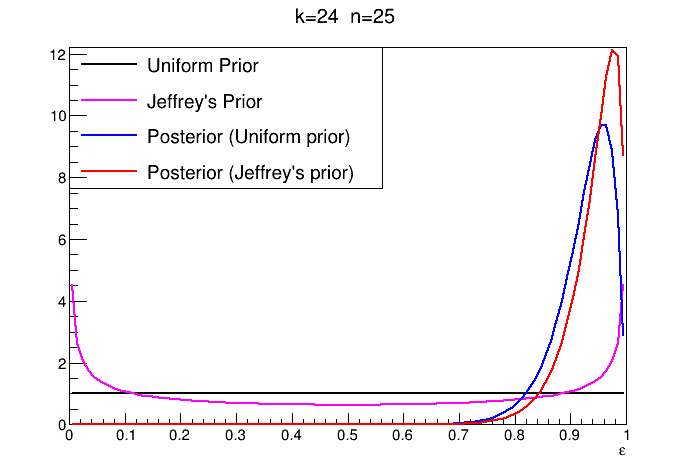

--- Uniform prior ----
    E(eff)=0.926    mode(eff)=0.960
    Confidence interval@68.3% CL : 0.879 < eff < 0.973

--- Jeffrey's prior ----
    E(eff)=0.942    mode(eff)=0.979
    Confidence interval@68.3% CL : 0.901 < eff < 0.983


In [5]:
plotBayesianPosterior(24,25);
c->Draw();

Now we use the [TEfficiency class in ROOT](https://root.cern.ch/doc/master/classTEfficiency.html), which implements all kinds of binomial confidence intervals

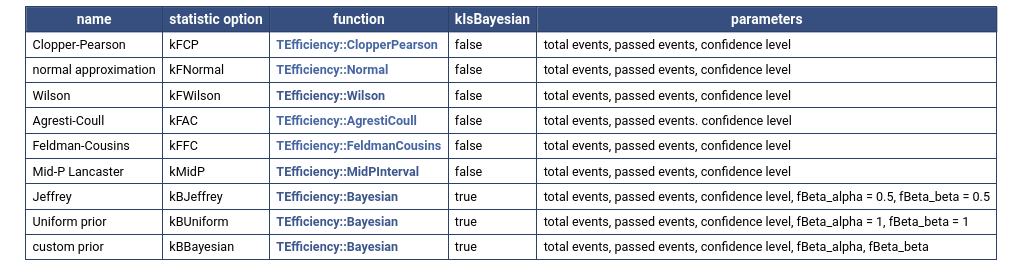

In [6]:
  TEfficiency* pEffWald =new TEfficiency(*hk, *hn);
  pEffWald->SetStatisticOption(TEfficiency::kFNormal);
  pEffWald->SetMarkerStyle(20);
  pEffWald->SetMarkerColor(1);
  pEffWald->SetTitle("Wald (naif)");
  // use this to change confidence level (default is 68.3%)
  // pEffWald->SetConfidenceLevel(.9);

  TEfficiency* pEffCP =new TEfficiency(*pEffWald);
  pEffCP->SetStatisticOption(TEfficiency::kFCP);
  pEffCP->SetLineColor(6);  pEffCP->SetMarkerColor(6);
  pEffCP->SetTitle("Clopper-Pearson");

  TEfficiency* pEffAC =new TEfficiency(*pEffWald);
  pEffAC->SetStatisticOption(TEfficiency::kFAC);
  pEffAC->SetLineColor(2);  pEffAC->SetMarkerColor(2);
  pEffAC->SetTitle("Agresti-Coull");
  
  TEfficiency* pEffFC =new TEfficiency(*pEffWald);
  pEffFC->SetStatisticOption(TEfficiency::kFFC);
  pEffFC->SetLineColor(3); pEffFC->SetMarkerColor(3); 
  pEffFC->SetTitle("Feldman-Cousins");
  
  TEfficiency* pEffBU =new TEfficiency(*pEffWald);
  pEffBU->SetStatisticOption(TEfficiency::kBUniform);
  pEffBU->SetLineColor(4); pEffBU->SetMarkerColor(4); 
  pEffBU->SetTitle("Bayesian, Uniform prior");
  
  TEfficiency* pEffBJ =new TEfficiency(*pEffWald);
  pEffBJ->SetStatisticOption(TEfficiency::kBJeffrey);
  pEffBJ->SetLineColor(9); pEffBJ->SetMarkerColor(9);
  pEffBJ->SetTitle("Bayesian, Jeffrey's prior");

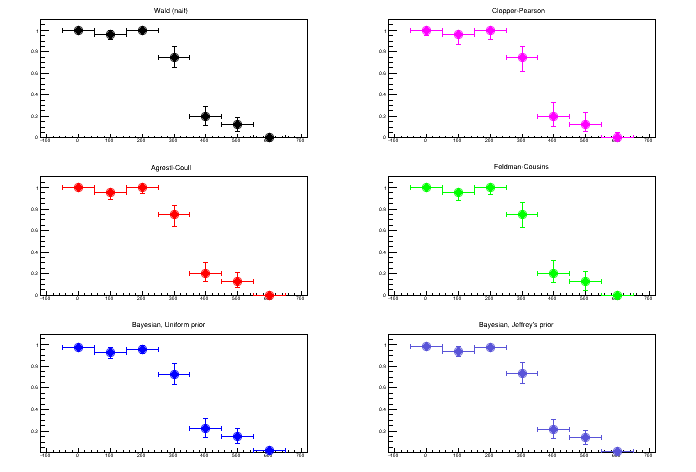

In [7]:
c->Clear();
c->Divide(2,3);
c->cd(1); pEffWald->Draw();
c->cd(2); pEffCP->Draw();
c->cd(3); pEffAC->Draw();
c->cd(4); pEffFC->Draw();
c->cd(5); pEffBU->Draw();
c->cd(6); pEffBJ->Draw();
c->cd(0);
c->Draw();

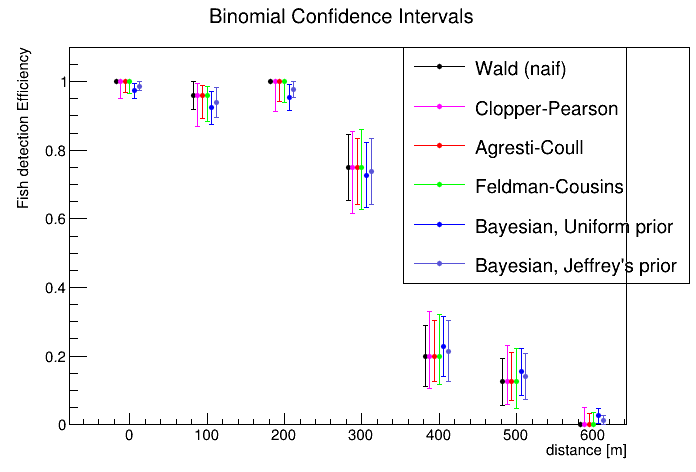

In [8]:
c->Clear();
TEfficiency* ci[6]={pEffWald, pEffCP, pEffAC, pEffFC, pEffBU, pEffBJ };
TGraphAsymmErrors* gci[6];
TLegend* l=new TLegend(.58,.4,.99,.9);
l->SetFillStyle(0);
for (int i=0; i<6; i++) {
    double x[Np];
    double eff[Np];
    double effl[Np];
    double effu[Np];
    for (int j=0; j<Np; j++) {
      x[j]=d[j]+6*(i-3);
      eff[j]=ci[i]->GetEfficiency(j+1);
      effl[j]=ci[i]->GetEfficiencyErrorLow(j+1);
      effu[j]=ci[i]->GetEfficiencyErrorUp(j+1);      
    }
    gci[i]=new TGraphAsymmErrors(Np,x,eff,0,0,effl,effu);
    gci[i]->SetLineColor(ci[i]->GetLineColor());
    gci[i]->SetMarkerColor(ci[i]->GetMarkerColor());
    gci[i]->SetMarkerStyle(20);
    gci[i]->SetMarkerSize(.6);
    gci[i]->Draw(i==0 ? "APE1" : "PE1");
    l->AddEntry(gci[i],ci[i]->GetTitle());
    
}
gci[0]->GetXaxis()->SetTitle("distance [m]");
gci[0]->GetYaxis()->SetTitle("Fish detection Efficiency");
gci[0]->SetTitle("Binomial Confidence Intervals");
l->Draw();
c->Draw();

# Now let's compare coverage of different methods

In [9]:
void coverage (int N=20, double CL=.95) {

  double geff[99];
  double gcov[6][99]   ;

  for (int e=1; e<100; e++) { // loop on different efficiency values
    double eff= (double)e/100.;
    geff[e-1]=eff;
    for (int i=0; i<6; i++) { // loop on different methods
      double coverage=0.;
      for (int k=0; k<=N; k++) { // loop on all possible results
        double correctInterval=false;
          // check if eff is in the confidence interval
        switch (i) {
        case 0: // Wald (normal approx.)
            correctInterval = eff >= TEfficiency::Normal(N,k,CL,false) &&
                              eff <= TEfficiency::Normal(N,k,CL,true);
          break;
        case 1: // Clopper-Pearson
           correctInterval = eff >= TEfficiency::ClopperPearson(N,k,CL,false) &&
                             eff <= TEfficiency::ClopperPearson(N,k,CL,true);
          break;
        case 2: // Agresti-Coull
          correctInterval = eff >= TEfficiency::AgrestiCoull(N,k,CL,false) &&
                            eff <= TEfficiency::AgrestiCoull(N,k,CL,true);
          break;
        case 3: //Feldman-Cousins
          correctInterval = eff >= TEfficiency::FeldmanCousins(N,k,CL,false) &&
                            eff <= TEfficiency::FeldmanCousins(N,k,CL,true);
          break;
        case 4: //Bayesian, Uniform prior
          correctInterval = eff >= TEfficiency::Bayesian(N,k,CL,1,1,false) &&
                            eff <= TEfficiency::Bayesian(N,k,CL,1,1,true);
          break;
        case 5: //Bayesian, Jeffrey's prior
          correctInterval = eff >= TEfficiency::Bayesian(N,k,CL,0.5,0.5,false) &&
                            eff <= TEfficiency::Bayesian(N,k,CL,0.5,0.5,true);
          break;
        }

        if (correctInterval)
          coverage += 100* ROOT::Math::binomial_pdf (k, eff, N);
       }
       gcov[i][e-1]=coverage;
    }
  }
  TGraph* cov[6];
  TLegend* l=new TLegend(.3,.15,.7,.55);
  for (int i=0; i<6; i++) {
    cov[i]=new TGraph(99,geff,gcov[i]);
    cov[i]->SetLineColor(ci[i]->GetLineColor());
    cov[i]->SetLineWidth(2);
    cov[i]->SetLineStyle(1+i);
    cov[i]->Draw(i==0 ? "AL" : "L");
    l->AddEntry(cov[i],ci[i]->GetTitle());
  }
  cov[0]->GetXaxis()->SetTitle("efficiency");
  cov[0]->GetYaxis()->SetTitle("Coverage (%)");
  cov[0]->SetTitle(Form("Coverage for CL=%.1f %% N=%d",CL*100.,N));
  l->Draw();
  TLine* line=new TLine(0,CL*100.,1,CL*100.);
  line->SetLineStyle(1);
  line->SetLineColor(2);
  line->Draw();
}

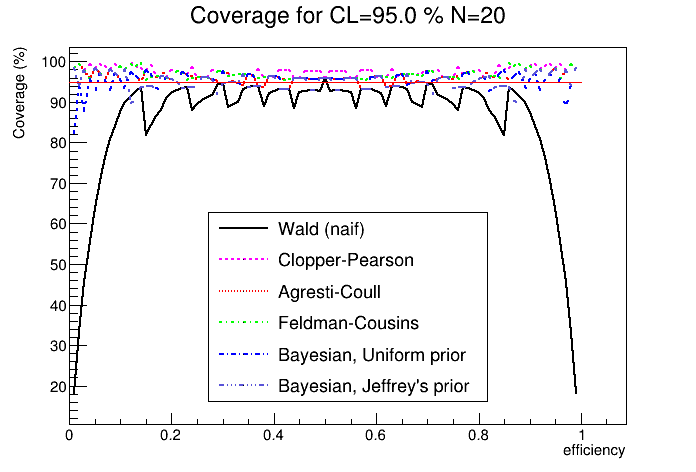

In [10]:
c->Clear();
coverage(20,.95);
c->Draw();